In [1]:
import pandas as pd
import warnings
import numpy as np
warnings.filterwarnings("ignore")
from pipeline.label_pipeline import FairnessLabelPipeline
from fairness_label.fairness_label import *
from visualization.visualize_plots import *
%matplotlib inline

Import error: No module named 'tensorflow'


# Experiment: Law School Dataset 

In [2]:
'''
target: application status (status)
sensitive 1: sex
sensitive 2: race
'''
data_file = "data/mylsn_cleaned_2.csv"

In [3]:
y_col = "status"
y_posi = ["Ac"]
na_symbol = "N/A"
sensi_atts = ["race", "sex"]
sensi_pro_valus = {"sex": ["female"], "race": ["black", "hispanic", "native-american"]}

In [4]:
base_steps = [("BalanceTargetSplitter", [0.7, 0.3], y_col),
              ("RandomSampler", 5000),  # sampler
              None,  # imputer
              None,  # scaler
              None,
              None,  # encoder
              None,
              None, #("AIF_DIRemover", y_col, debias_focus_att, 1.0),  # fair-preprocessor
              ("SK_LogisticRegression", y_col),  # model
              None  # fair-post-postprocessor
             ]

cur_pip = FairnessLabelPipeline(data_file, y_col, y_posi, 
                                sensitive_atts = sensi_atts, 
                                protected_values = sensi_pro_valus, 
                                na_mark=na_symbol)

In [5]:
before_test, after_test = cur_pip.run_pipeline(base_steps, return_test=True, output_interdata=True)

BalanceTargetSplitter(input_df, [0.7, 0.3], 'status')
!!!!!!! train (148537, 8) !!!!!!!
Current train data after BalanceTargetSplitter 
 Stored in  C:\Users\tbl245\Desktop\deml-project-4\data\inter_data/my_BalanceTargetSplitter_RandomSampler_SK_LogisticRegression/train/mylsn_cleaned_2__after__BalanceTargetSplitter.csv

!!!!!!! test (63660, 8) !!!!!!!
Current test data after BalanceTargetSplitter 
 Stored in  C:\Users\tbl245\Desktop\deml-project-4\data\inter_data/my_BalanceTargetSplitter_RandomSampler_SK_LogisticRegression/test/mylsn_cleaned_2__after__BalanceTargetSplitter.csv

Done Splitter

RandomSampler(input_df, 5000)
RandomSampler(input_df, 5000)
!!!!!!! train (5000, 8) !!!!!!!
Current train data after BalanceTargetSplitte RandomSampler 
 Stored in  C:\Users\tbl245\Desktop\deml-project-4\data\inter_data/my_BalanceTargetSplitter_RandomSampler_SK_LogisticRegression/train/mylsn_cleaned_2__after__BalanceTargetSplitte__RandomSampler.csv

!!!!!!! test (5000, 8) !!!!!!!
Current test data 

## Static Labels 

In [6]:
sl_sex = get_static_label(after_test, [sensi_atts[1]], y_col)
sl_sex

{'female': {'Ac': 0.357, 'Re': 0.354}, 'male': {'Ac': 0.643, 'Re': 0.646}}

In [7]:
sl_race_sex = get_static_label(after_test, sensi_atts, y_col)
sl_race_sex

{('asian&more', 'female'): {'Ac': 0.334, 'Re': 0.338},
 ('asian&more', 'male'): {'Ac': 0.666, 'Re': 0.662},
 ('black&more', 'female'): {'Ac': 0.467, 'Re': 0.421},
 ('black&more', 'male'): {'Ac': 0.533, 'Re': 0.579}}

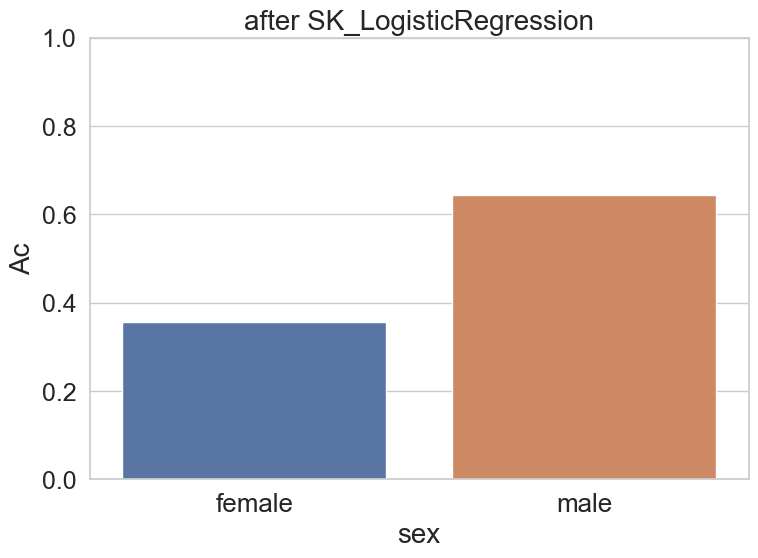

In [8]:
draw_bar_plot(sl_sex, y_posi[0], [sensi_atts[1]], "SK_LogisticRegression")

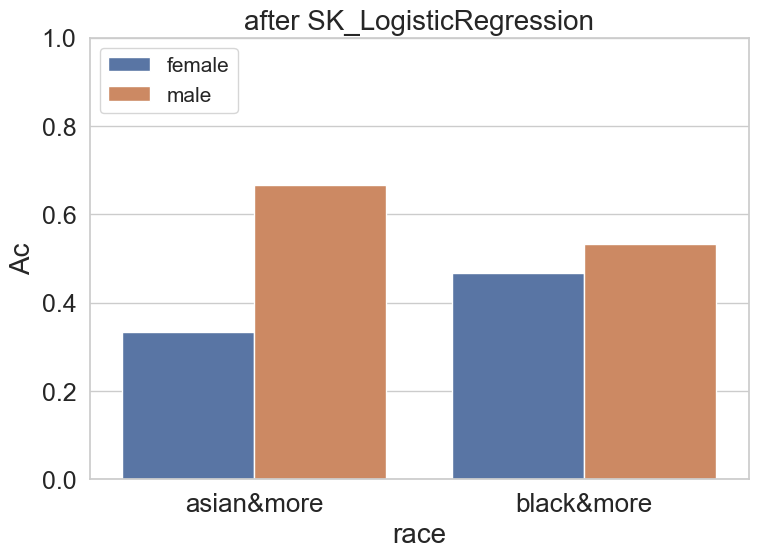

In [9]:
draw_bar_plot(sl_race_sex, y_posi[0], sensi_atts, "SK_LogisticRegression")

## Performance Labels

In [10]:
pl_race = get_performance_label(after_test, [sensi_atts[0]], y_col, y_posi[0])
pl_race

{'asian&more': {'PR': 0.587, 'TPR': 1.0, 'TNR': 0.0, 'FPR': 1.0, 'FNR': 0.0},
 'black&more': {'PR': 0.617, 'TPR': 1.0, 'TNR': 0.0, 'FPR': 1.0, 'FNR': 0.0}}

In [11]:
pl_race_sex = get_performance_label(after_test, sensi_atts, y_col, y_posi[0])
pl_race_sex

{('asian&more', 'female'): {'PR': 0.59,
  'TPR': 1.0,
  'TNR': 0.0,
  'FPR': 1.0,
  'FNR': 0.0},
 ('asian&more', 'male'): {'PR': 0.585,
  'TPR': 1.0,
  'TNR': 0.0,
  'FPR': 1.0,
  'FNR': 0.0},
 ('black&more', 'female'): {'PR': 0.593,
  'TPR': 1.0,
  'TNR': 0.0,
  'FPR': 1.0,
  'FNR': 0.0},
 ('black&more', 'male'): {'PR': 0.637,
  'TPR': 1.0,
  'TNR': 0.0,
  'FPR': 1.0,
  'FNR': 0.0}}

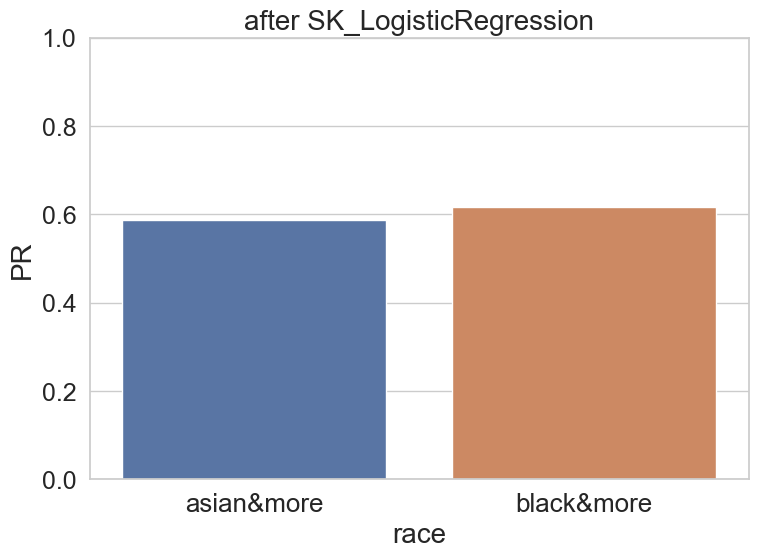

In [12]:
draw_bar_plot(pl_race, "PR", [sensi_atts[0]], "SK_LogisticRegression")

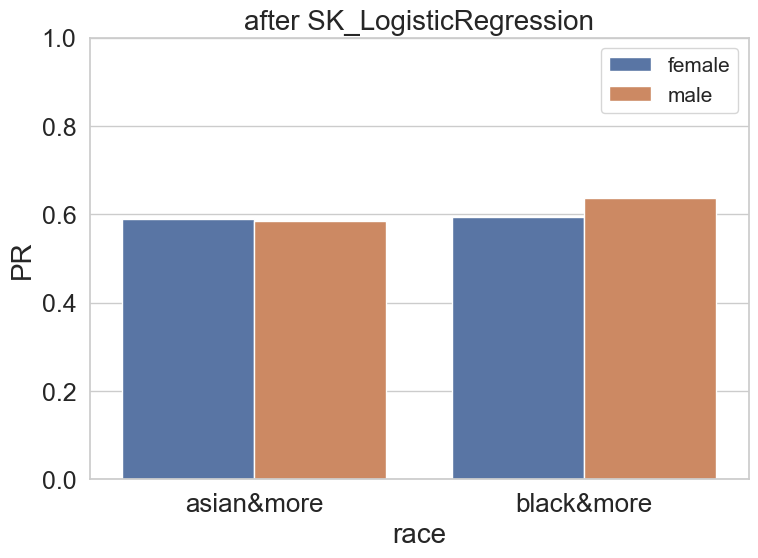

In [13]:
draw_bar_plot(pl_race_sex, "PR", sensi_atts, "SK_LogisticRegression", True)

# Cleaning: Law School Dataset

### The below steps were used to clean the data for the operations above

In [ ]:
sensi_atts = ["sex", "race"]

# Data Cleaning

In [ ]:
'''
target: application status (status)
sensitive 1: race
sensitive 2: sex
'''
data_file = "data/mylsn_raw.csv"
data = pd.read_csv(data_file)

In [ ]:
data

In [ ]:
data.columns

In [ ]:
data.drop('Unnamed: 0', axis = 1, inplace=True)

In [ ]:
data["international"].value_counts()

In [ ]:
data = data[data["international"] == 0]

In [ ]:
data["international"].value_counts()

In [ ]:
data.dropna(subset = sensi_atts, inplace = True)

In [ ]:
data.shape

### Target: Status

In [ ]:
data["status"].value_counts()

In [ ]:
'''
Since there are more than two categories for application status, we need binarize this 
variable. [Ac, AcWa]="Ac", [Pe, Re, Wa, ReWa]="Re"
DataFrame.replace(self, to_replace=None, value=None, inplace=False, limit=None, regex=False, method='pad')
'''
for Re in ["Pe", "Wa", "ReWa"]:
    data["status"].replace(Re, "Re", inplace=True)
data["status"].replace("AcWa", "Ac", inplace=True)
data["status"].value_counts()

### Sensitive Attribute 1: Sex

In [ ]:
data["sex"].value_counts()

In [ ]:
data["sex"] = data["sex"].str.lower()
data["sex"].value_counts()

### Sensitive Attribute 2: Race

In [ ]:
data["race"].value_counts()

In [ ]:
data["race"] = data["race"].str.lower()

In [ ]:
dict(data["race"].value_counts())

In [ ]:
white = []
exclude = ["/", "on", "ot"]
for var in dict(data["race"].value_counts()).keys():
    if "w" == var:
        white.append(var)
    elif "c" == var:
        white.append(var)
    elif 'caucasion' == var:
        white.append(var)

    elif "te/ca" in var:
        white.append(var)
    elif "te/ma" in var:
        white.append(var)
    elif "te/fe" in var:
        white.append(var)
    elif "le/w" in var:
        white.append(var)
    
    elif "white" in var:
        if "male" in var:
            white.append(var)
        elif "female" in var:
            white.append(var)
        
    elif "wh" in var:
        if "/" not in var:
            if "on" not in var:
                if "ot" not in var:
                    white.append(var)
                
    elif "cau" in var:
        if "/" not in var:
            if "on" not in var:
                if "ot" not in var:
                    white.append(var)

In [ ]:
for variant in white:
    data["race"].replace(variant, "white", inplace=True)

In [ ]:
black = []
for var in dict(data["race"].value_counts()).keys():
    if 'frican' in var:
        black.append(var)
    elif "lack" in var:
        black.append(var)
    elif "aa" == var:
        black.append(var)
    elif "blk" == var:
        black.append(var)
    elif "b" == var:
        black.append(var)

In [ ]:
for variant in black:
    data["race"].replace(variant, "black", inplace=True)

In [ ]:
asian = []
for var in dict(data["race"].value_counts()).keys():
    if "asian" in var:
        asian.append(var)
    elif "/asian" in var:
        asian.append(var)
    elif "chinese" in var:
        asian.append(var)
    elif "vietnam" in var:
        asian.append(var)
    elif "taiwan" in var:
        asian.append(var)
    elif "korean" in var:
        asian.append(var)
    elif "filipino" in var:
        asian.append(var)
    elif "yellow" == var:
        asian.append(var)
    elif "east" in var:
        if "india" in var:
            asian.append(var)

In [ ]:
for variant in asian:
    data["race"].replace(variant, "asian", inplace=True)

In [ ]:
hispanic = []
for var in dict(data["race"].value_counts()).keys():
    if 'puerto rican' == var:
        hispanic.append(var)
    if 'cuban' == var:
        hispanic.append(var)
    elif "h" == var:
        hispanic.append(var)
    elif "his" in var:
        hispanic.append(var)
    elif "lat" in var:
        hispanic.append(var)
    elif "mex" in var:
        hispanic.append(var)

In [ ]:
for variant in hispanic:
    data["race"].replace(variant, "hispanic", inplace=True)

In [ ]:
native = []
for var in dict(data["race"].value_counts()).keys():
    if 'native' in var:
        native.append(var)
    elif 'indian'== var:
        native.append(var)
    elif "kee" in var:
        native.append(var)

In [ ]:
for variant in native:
    data["race"].replace(variant, "native-american", inplace=True)

In [ ]:
data["race"].value_counts()

In [ ]:
races = ["white", "black", "asian", "hispanic", "native-american"]
data_ = data[data.race.isin(races)]
data_["race"].value_counts()

In [ ]:
data_.to_csv("mylsn_cleaned.csv", index=False)